## Exploration of the parameters for a good ensemble model

`grant_tagger.py` was run with all combinations of the following vectorizers and classifiers:

Vectorizer: 
1. Count
2. TF-IDF
3. BERT
4. SciBERT

Classifier: 
1. Naïve Bayes
2. SVM
3. Logistic regression

This outputted in **12 trained models**. We also have the predictions of each model on a test set.

Test each combination of models and the number that need to agree to find the best parameters for an ensemble model. This information can be put into a config file for use in `ensemble_grant_tagger.py` to make future predictions.



In [1]:
import json
import itertools
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score
)

## Load data

In [2]:
date_model_test ='210401'

In [3]:
# Test performance of each model
if int(date_model_test) < 210331:
    with open(f'../data/processed/model_test_results/models_summary_{date_model_test}.jsonl') as f:
        model_results = json.load(f)
        
    # The test predictions for each model
    model_predictions = pd.read_csv(f'../data/processed/model_test_results/model_test_results_{date_model_test}.csv')

    # Merge the model test predictions with the actual test values
    test_data = pd.read_csv(f'../data/processed/model_test_results/test_data_{date_model_test}.csv')
    model_predictions = pd.merge( 
        model_predictions,
        test_data[['Internal ID', 'Relevance code']],
        how = 'left',
        on = ['Internal ID']
        )
else:
    # The test truth and predictions for each model
    training_info_file = os.path.join('..', 'models', date_model_test, 'training_information.json')
    all_models_info = {}
    all_models_probs = {}
    with open(training_info_file, 'r') as file:
        for line in file:
            model_data = json.loads(line)
            model_name = list(model_data.keys())[0]
            test_results = pd.DataFrame([m for m in model_data[model_name].values() if m['Test/train']=='Test']) 
            all_models_info[model_name] = test_results['Prediction']
            all_models_probs[model_name] = test_results['Prediction probability']

    model_predictions = pd.DataFrame(all_models_info)
    model_names = model_predictions.columns
    # The ground truth will be the same for every model,
    # so just save out for the last line
    model_predictions['Relevance code'] = test_results['Truth']
    model_predictions['Internal ID'] = [grant_id for grant_id, m in model_data[model_name].items() if m['Test/train']=='Test']

    # The probabilities for each model prediction (will map to rows of model_predictions)
    model_predictions_probs = pd.DataFrame(all_models_probs)
    
    model_results = {}
    for model_name in model_names:
        y_true = model_predictions['Relevance code']
        y_pred = model_predictions[model_name]
        model_results[model_name] = {
                    'f1': f1_score(y_true, y_pred),
                    'precision_score': precision_score(y_true, y_pred),
                    'recall_score': recall_score(y_true, y_pred)
                    }

model_results = pd.DataFrame(model_results).T
model_results['model_name'] = ['_'.join(m.split('_')[0:-1]) for m in model_results.index]
model_results['Type'] = ['Original model']*len(model_results)

In [4]:
model_results

,f1,precision_score,recall_score,model_name,Type
count_naive_bayes_210401,0.827957,0.726415,0.9625,count_naive_bayes,Original model
count_SVM_210401,0.816327,0.895522,0.7500,count_SVM,Original model
count_log_reg_210401,0.825000,0.825000,0.8250,count_log_reg,Original model
tfidf_naive_bayes_210401,0.810526,0.700000,0.9625,tfidf_naive_bayes,Original model
tfidf_SVM_210401,0.827586,0.923077,0.7500,tfidf_SVM,Original model
tfidf_log_reg_210401,0.823529,0.863014,0.7875,tfidf_log_reg,Original model
bert_naive_bayes_210401,0.752577,0.640351,0.9125,bert_naive_bayes,Original model
bert_SVM_210401,0.848485,0.823529,0.8750,bert_SVM,Original model
bert_log_reg_210401,0.894410,0.888889,0.9000,bert_log_reg,Original model
scibert_naive_bayes_210401,0.811111,0.730000,0.9125,scibert_naive_bayes,Original model


In [5]:
model_predictions.head(2)

,count_naive_bayes_210401,count_SVM_210401,count_log_reg_210401,tfidf_naive_bayes_210401,tfidf_SVM_210401,tfidf_log_reg_210401,bert_naive_bayes_210401,bert_SVM_210401,bert_log_reg_210401,scibert_naive_bayes_210401,scibert_SVM_210401,scibert_log_reg_210401,Relevance code,Internal ID
0,1,1,1,1,1,1,1,1,1,1,1,1,1,107599/Z/15/Z
1,1,0,0,1,0,0,1,0,0,0,0,0,0,214933/Z/18/Z


## Visualise the precision/recall for each model

In [6]:
min_precision = model_results['precision_score'].min()
max_precision = model_results['precision_score'].max()
print((min_precision, max_precision))

min_recall = model_results['recall_score'].min()
max_recall = model_results['recall_score'].max()
print((min_recall, max_recall))

min_both = min(min_precision, min_recall)-0.1
max_both = min(max_precision, max_recall)+0.1

(0.6403508771929824, 0.9230769230769231)
(0.75, 0.9625)


In [7]:
def pick_col_shape(model_name):
    for vec_name in colour_map.keys():
        if vec_name in model_name:
            col = colour_map[vec_name]
            break
        else:
            # bert
            col = 'blue'
    for class_name in shape_map.keys():
        if class_name in model_name:
            shape = shape_map[class_name]
            
    return col, shape

In [8]:
colour_map = {'scibert': 'green', 'count': 'red', 'tfidf': 'orange'}
shape_map = {'log_reg': 'v', 'SVM': 'x', 'naive_bayes': '.'}

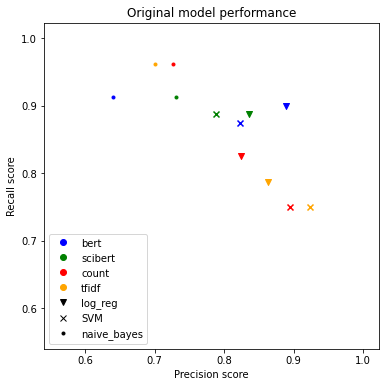

In [9]:
fig, ax = plt.subplots(figsize=(6,6))
ax.set(xlim=(min_both,max_both),
    ylim=(min_both,max_both))
for k, v in model_results.iterrows():
    col, shape = pick_col_shape(v['model_name'])
    ax.scatter(
    v['precision_score'],
    v['recall_score'],
    c = col,
    marker=shape,
    label='point')

ax.set(xlabel='Precision score', ylabel='Recall score', 
       title='Original model performance');

from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], marker='o', color='blue', linewidth=0)]
for vec_name, col in colour_map.items():
    custom_lines.append(Line2D([0], [0], marker='o', color=col, linewidth=0))
for class_name, shape in shape_map.items():
    custom_lines.append(Line2D([0], [0], marker=shape, color='k', linewidth=0))
     
ax.legend(custom_lines, ['bert']+list(colour_map.keys())+list(shape_map.keys()), loc='lower left')

## Prediction probabilities

In [10]:
tech_probs = []
not_tech_probs = []
for row_i, row in model_predictions_probs.iterrows():
    for col_name, pred_prob in enumerate(row):
        if model_predictions.iloc[row_i][col_name]==1:
            tech_probs.append(pred_prob)
        else:
            not_tech_probs.append(pred_prob)

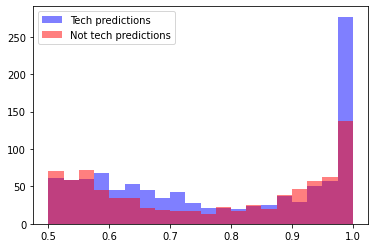

In [11]:
plt.hist(tech_probs, bins=20, alpha = 0.5, color='blue', label='Tech predictions');
plt.hist(not_tech_probs, bins=20, alpha = 0.5, color='red', label='Not tech predictions');
plt.legend();

## Test ensemble models using all combinations of models

In [12]:
# Get every combination of models
models_list = model_results.index.tolist()
all_combinations = []
for r in range(1, len(models_list) + 1):
    combinations_object = itertools.combinations(models_list, r)
    combinations_list = list(combinations_object)
    all_combinations += combinations_list
len(all_combinations)

4095

In [13]:
# Find the test performance for each model combition and number of models that need to agree
labels = model_predictions['Relevance code']

average_type = 'binary'
all_combos_scores = []
for i, model_combination in enumerate(all_combinations):
    if i%1000==0:
        print(i)
    for prob_thresh in np.linspace(0.5,0.95,20):
        # If a tech prediction is >= probability threshold then keep as tech, 
        # otherwise set to 0
        pred_threshold_mask = model_predictions_probs[list(model_combination)] >= prob_thresh
        model_combos_predictions = model_predictions[list(model_combination)]*pred_threshold_mask
#         model_combos_predictions = model_predictions[list(model_combination)]
        # How many of the models agree on tech grant prediction?
        prediction_sums = model_combos_predictions.sum(axis=1)
#         if (model_combos_predictions==1).sum().sum() != 0:
#             # Only include if there is at least one prediction is for a tech grant
        for num_agree in range(1, len(model_combination)+1):
            # Calculate test metrics
            y_pred = [1 if pred_sum >= num_agree else 0 for pred_sum in prediction_sums]
            all_combos_scores.append({
                'Type': 'Ensemble model',
                'model_name': model_combination,
                'num_models': len(model_combination),
                'probability threshold': prob_thresh,
                'num_agree': num_agree,
                'f1': f1_score(labels, y_pred, average=average_type),
                'precision_score': precision_score(labels, y_pred, zero_division=0, average=average_type),
                'recall_score': recall_score(labels, y_pred, zero_division=0, average=average_type)
                })
all_combos_scores_df = pd.DataFrame(all_combos_scores)

0
1000
2000
3000
4000


In [14]:
# How many BERT models are there in the ensemble
all_combos_scores_df['num_bert'] = all_combos_scores_df['model_name'].apply(lambda x: sum(['bert' in model for model in list(x)]))

In [15]:
len(all_combos_scores_df)

491520

## Save out
Not all data needs to be saved out as there are a lot of repeats.
Less models and less models involving BERT is good for speed - so order by these and remove duplicates.

In [16]:
all_combos_scores_df_small = all_combos_scores_df.copy()
all_combos_scores_df_small.sort_values(by = ['num_models', 'num_bert'], inplace=True)
all_combos_scores_df_small.drop_duplicates(subset = ['precision_score', 'recall_score'], inplace=True)
len(all_combos_scores_df_small)

523

In [17]:
all_combos_scores_df_small.to_csv(os.path.join('..', 'models', date_model_test, 'ensemble_information.json'))

## Plot all points

In [18]:
min_all_ensemble = all_combos_scores_df[['precision_score', 'recall_score']].min().min() - 0.05
max_all_ensemble = all_combos_scores_df[['precision_score', 'recall_score']].max().max() + 0.05

In [19]:
all_combos_scores_df['Random precision noise'] = np.random.uniform(-0.01, 0.01, len(all_combos_scores_df))
all_combos_scores_df['Random recall noise'] = np.random.uniform(-0.01, 0.01, len(all_combos_scores_df))
all_combos_scores_df['precision_score_jitter'] = all_combos_scores_df[['precision_score', 'Random precision noise']].sum(axis=1)
all_combos_scores_df['recall_score_jitter'] = all_combos_scores_df[['recall_score', 'Random recall noise']].sum(axis=1)

/Users/gallaghe/Code/nutrition-labels/build/virtualenv/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


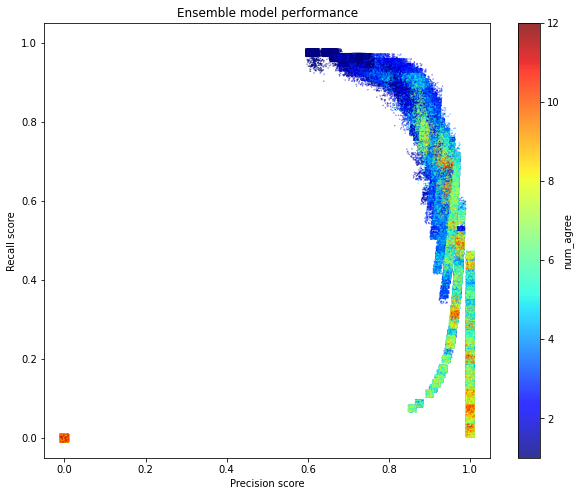

In [20]:
axis_lims = (min_all_ensemble, max_all_ensemble)

all_combos_scores_df.plot.scatter(
    'precision_score_jitter',
    'recall_score_jitter',
    figsize=(10,8),
    c='num_agree',
    alpha=0.8,
    s=0.1,
    colormap="jet",
    sharex=False,
    xlim=axis_lims,
    ylim=axis_lims,
    title='Ensemble model performance',
    xlabel='Precision score',
    ylabel='Recall score'
);

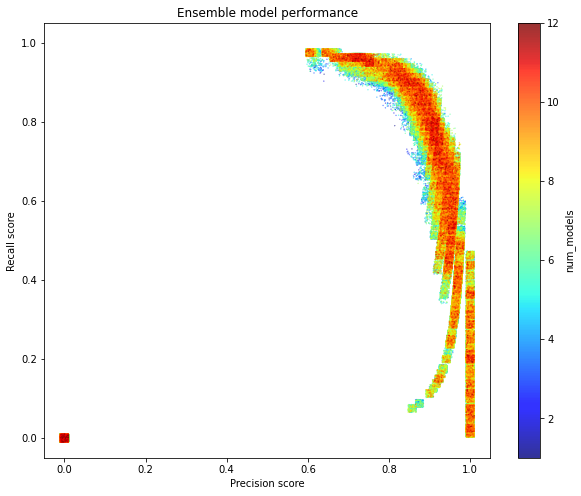

In [21]:
axis_lims = (min_all_ensemble, max_all_ensemble)

all_combos_scores_df.plot.scatter(
    'precision_score_jitter',
    'recall_score_jitter',
    figsize=(10,8),
    c='num_models',
    colormap="jet",
    alpha=0.8,
    s=0.1,
    sharex=False,
    xlim=axis_lims,
    ylim=axis_lims,
    title='Ensemble model performance',
    xlabel='Precision score',
    ylabel='Recall score'
);

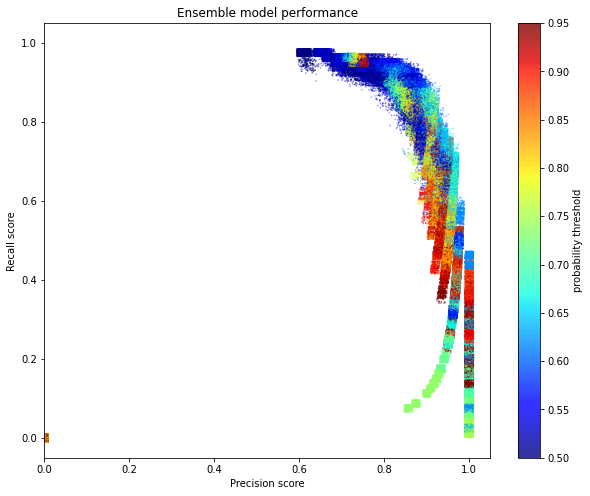

In [22]:
axis_lims = (min_all_ensemble, max_all_ensemble)

all_combos_scores_df.plot.scatter(
    'precision_score_jitter',
    'recall_score_jitter',
    figsize=(10,8),
    c='probability threshold',
    colormap="jet",
    alpha=0.8,
    s=0.1,
    sharex=False,
    xlim=(0,1.05),
    ylim=axis_lims,
    title='Ensemble model performance',
    xlabel='Precision score',
    ylabel='Recall score'
);

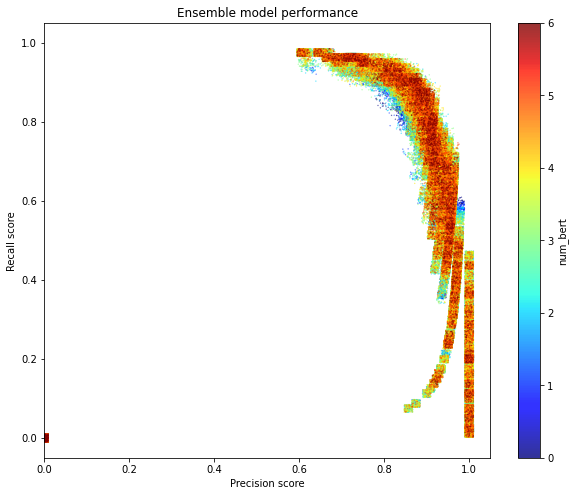

In [23]:
axis_lims = (min_all_ensemble, max_all_ensemble)

all_combos_scores_df.plot.scatter(
    'precision_score_jitter',
    'recall_score_jitter',
    figsize=(10,8),
    c='num_bert',
    colormap="jet",
    alpha=0.8,
    s=0.1,
    sharex=False,
    xlim=(0,1.05),
    ylim=axis_lims,
    title='Ensemble model performance',
    xlabel='Precision score',
    ylabel='Recall score'
);

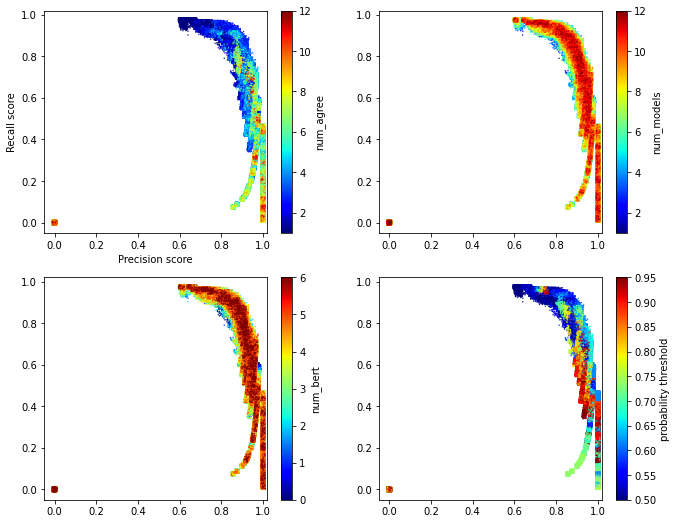

In [24]:
x_axis_lims = (-0.05,1.02)
y_axis_lims = (-0.05,1.02)
point_size = 0.2
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(11,9));

all_combos_scores_df.plot.scatter(
    ax=axes[0,0], x='precision_score_jitter', y='recall_score_jitter',
    c='num_agree', colormap="jet", xlim=x_axis_lims, ylim=y_axis_lims, s=point_size,
    xlabel='Precision score', ylabel='Recall score')
all_combos_scores_df.plot.scatter(
    ax=axes[0,1], x='precision_score_jitter', y='recall_score_jitter',
    c='num_models', colormap="jet", xlim=x_axis_lims, ylim=y_axis_lims, s=point_size,
    xlabel='', ylabel='')
all_combos_scores_df.plot.scatter(
    ax=axes[1,0], x='precision_score_jitter', y='recall_score_jitter',
    c='num_bert', colormap="jet", xlim=x_axis_lims, ylim=y_axis_lims, s=point_size,
    xlabel='', ylabel='')
all_combos_scores_df.plot.scatter(
    ax=axes[1,1], x='precision_score_jitter', y='recall_score_jitter',
    c='probability threshold', colormap="jet", xlim=x_axis_lims, ylim=y_axis_lims,
    s=point_size, xlabel='', ylabel='');

## All together, just for high scores

In [25]:
all_combos_scores_df_high = all_combos_scores_df.copy().loc[
    (
        (all_combos_scores_df['precision_score'] >= 0.85) & 
        (all_combos_scores_df['recall_score'] >= 0.8)
    )
]
len(all_combos_scores_df_high)

73956

/Users/gallaghe/Code/nutrition-labels/build/virtualenv/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


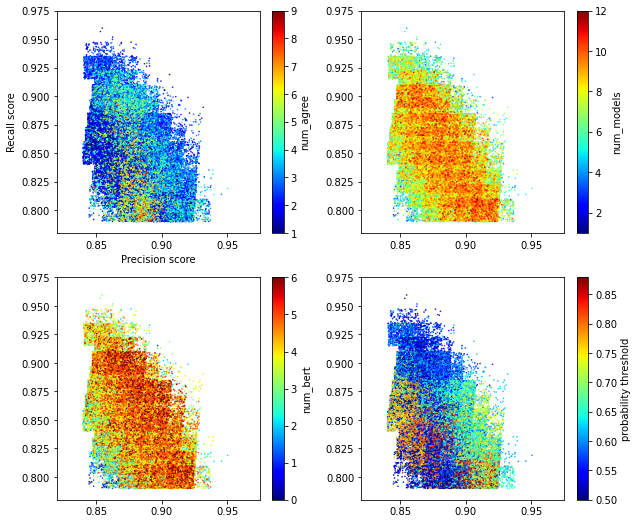

In [26]:
x_axis_lims = (0.82,0.975)
y_axis_lims = (0.78,0.975)
point_size = 0.3
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,9));

all_combos_scores_df_high.plot.scatter(
    ax=axes[0,0], x='precision_score_jitter', y='recall_score_jitter',
    c='num_agree', colormap="jet", xlim=x_axis_lims, ylim=y_axis_lims, s=point_size,
    xlabel='Precision score', ylabel='Recall score')
all_combos_scores_df_high.plot.scatter(
    ax=axes[0,1], x='precision_score_jitter', y='recall_score_jitter',
    c='num_models', colormap="jet", xlim=x_axis_lims, ylim=y_axis_lims, s=point_size,
    xlabel='', ylabel='')
all_combos_scores_df_high.plot.scatter(
    ax=axes[1,0], x='precision_score_jitter', y='recall_score_jitter',
    c='num_bert', colormap="jet", xlim=x_axis_lims, ylim=y_axis_lims, s=point_size,
    xlabel='', ylabel='')
all_combos_scores_df_high.plot.scatter(
    ax=axes[1,1], x='precision_score_jitter', y='recall_score_jitter',
    c='probability threshold', colormap="jet", xlim=x_axis_lims, ylim=y_axis_lims,
    s=point_size, xlabel='', ylabel='');

### Plot ensemble results with original single model results

In [27]:
combined_results = pd.concat([model_results, all_combos_scores_df])

In [28]:
# We want to colour original models by vectoriser used, so set up a colour column for this
vects = ['scibert', 'count', 'tfidf']
model_vect = []
for _, row in combined_results.iterrows():
    if row['Type']== 'Ensemble model':
        model_vect.append('ensemble')
    else:
        which_vect = [i for i in vects if i in row['model_name']]
        if len(which_vect)==0:
            model_vect.append('bert')
        else:
            model_vect.append(which_vect[0])
    
combined_results['Vectorizer type'] = model_vect
colour_map = {'scibert': 'green', 'bert': 'blue', 'count': 'red', 'tfidf': 'orange', 'ensemble': 'black'}
combined_results['Vectorizer type colour'] = [colour_map[c] for c in combined_results['Vectorizer type']]

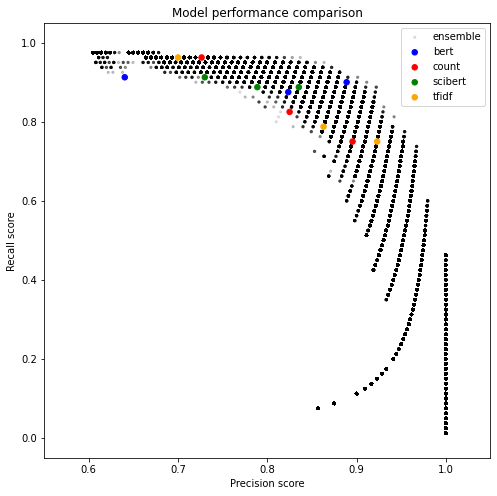

In [30]:
vectorizer_groups = combined_results.groupby('Vectorizer type')

# Plot the ensemble results first since there are so many
group_names = list(vectorizer_groups.groups.keys())
group_names.remove('ensemble')
group_order = ['ensemble'] + group_names

fig, ax = plt.subplots(1, figsize=(8,8))
ax.set(xlim=(0.55, max_all_ensemble),
    ylim=(min_all_ensemble, max_all_ensemble))
for label in group_order:
    if label == 'ensemble':
        alpha = 0.1
        size = 5
    else:
        alpha = 1
        size = 30
    group = vectorizer_groups.get_group(label)
    ax.scatter(
        group['precision_score'],
        group['recall_score'],
        c=group['Vectorizer type colour'],
        label=label,
        alpha=alpha,
        s=size
    )

ax.set(xlabel='Precision score', ylabel='Recall score', 
       title='Model performance comparison')
ax.legend()
plt.show()

## The highest performing ensemble models
- high precision
- high recall
- doesn't take too long - not too many BERT or SciBERT vectorizers in the ensemble

In [72]:
precision_threshold = 0.91
recall_threshold = 0.9
min_bert = 2

In [73]:
best_results = all_combos_scores_df.loc[
    (
        (all_combos_scores_df['precision_score'] >= precision_threshold) & 
        (all_combos_scores_df['recall_score'] >= recall_threshold) &
        (all_combos_scores_df['num_bert'] <= min_bert)
    )
]
print(len(best_results))
best_results

4


,Type,model_name,num_models,probability threshold,num_agree,f1,precision_score,recall_score,num_bert,Random precision noise,Random recall noise,precision_score_jitter,recall_score_jitter
13147,Ensemble model,"(tfidf_SVM_210401, bert_naive_bayes_210401, be...",3,0.547368,2,0.90566,0.911392,0.9,2,0.008905,-0.001217,0.920297,0.898783
25370,Ensemble model,"(count_naive_bayes_210401, tfidf_SVM_210401, b...",4,0.547368,3,0.90566,0.911392,0.9,2,-0.009344,-0.009916,0.902048,0.890084
50169,Ensemble model,"(tfidf_SVM_210401, tfidf_log_reg_210401, bert_...",4,0.547368,2,0.90566,0.911392,0.9,2,-0.000541,-0.000520,0.910851,0.899480
81792,Ensemble model,"(count_naive_bayes_210401, tfidf_SVM_210401, t...",5,0.547368,3,0.90566,0.911392,0.9,2,-0.007042,0.002704,0.904351,0.902704


In [59]:
# Note: there may be a reason to change the defintion of 'optimal'
# here, or even manually set it to another index.
# Here we assume the best model was the first one with the least
# number of models, from the list which have precision/recall values
# over certain thresholds - but there may be other criteria
optimal_model_i = best_results.sort_values('num_models').index[0]
optimal_model_i

13147

In [60]:
num_agree = best_results.loc[optimal_model_i]['num_agree']
model_combination = list(best_results.loc[optimal_model_i]['model_name'])
model_combination

['tfidf_SVM_210401', 'bert_naive_bayes_210401', 'bert_log_reg_210401']

In [67]:
prob_thresh = 0.55
pred_threshold_mask = model_predictions_probs[list(model_combination)] >= prob_thresh
model_combos_predictions = model_predictions[list(model_combination)]*pred_threshold_mask
prediction_sums = model_combos_predictions.sum(axis=1)
y_pred = [1 if pred_sum >= num_agree else 0 for pred_sum in prediction_sums]

In [68]:
print(classification_report(labels, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.91      0.90        77
           1       0.91      0.89      0.90        80

    accuracy                           0.90       157
   macro avg       0.90      0.90      0.90       157
weighted avg       0.90      0.90      0.90       157



In [69]:
print(confusion_matrix(labels, y_pred))

[[70  7]
 [ 9 71]]
